<a href="https://colab.research.google.com/github/nhareesha/MLAI/blob/main/NN/TF_lowlevel_api_MNIS_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist


# Prepare MNIST data.

- Load dataset to x_train y_train x_test and y_test
- Normalize pixel values to be between 0 and 1.
- Intensity of each pixel value id b/w 0 to 255 Grey scale (0 - black to 255 - black)
- Scale the dataset to avoid exploding gradients and vanishing gradients.
- Flatten datasets to 1-D arrays




In [43]:
num_classes = 10      # (0 - 9 digits)
num_features = 784    #(28 * 28 pixels)


# Load Dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(np.shape(x_train)) # 60k training samples
print(np.shape(y_train))

print(np.shape(x_test)) # 10K testing samples
print(np.shape(y_test))


# Normalize pixel values to be between 0 and 1 - SCALING
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])



(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


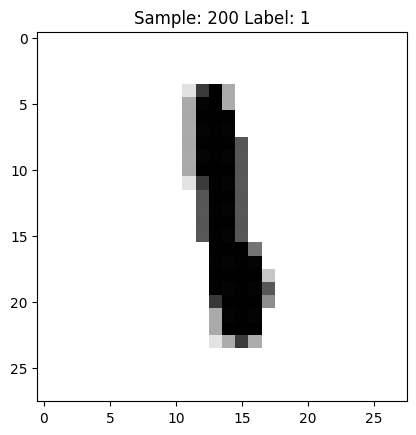

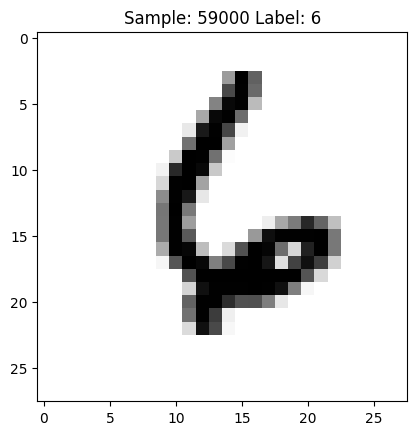

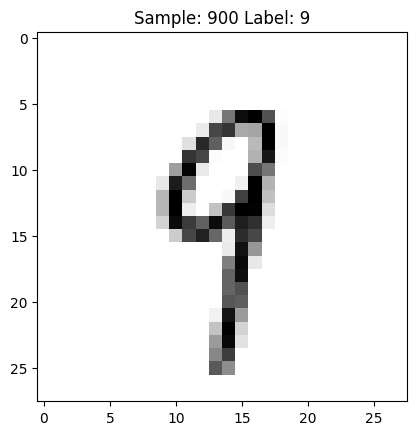

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
  label = y_train[num]

  # Reshape 784 values to 28 by 28 pixels

  image = x_train[num].reshape([28, 28])

  plt.title('Sample: %d Label: %d' % (num, label))
  plt.imshow(image, cmap = plt.get_cmap('gray_r'))
  plt.show()


display_sample(200)
display_sample(59000)
display_sample(900)

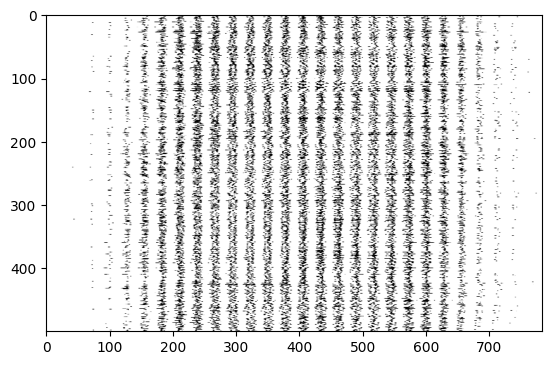

In [45]:
images = x_train[0].reshape([1, 784])

for i in range(1, 500):
  images = np.concatenate((images, x_train[i].reshape([-1, 784])))

plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

# NN topology

- 1 input layer with 784 features
- 1 output layer with 10 classes
- 3 hidden layer with 512 neurons and activation as ReLU
 - 1st hiddenlayer with 512 neurons
 - 2nd hidden layer with 256 neurons
 - 3rd layer with 128 neurons


# Weights and Biases

- 1st hidden layer weight matrix , `1st hidden layer X input layer`
 - `512 X 784` , by tensorflow does not do WX, instead XW, so the weight mateix uses - `784 X 512` . Both of them are same, as long as matmul is aligned.
- 2nd hidden layer - 512 X 256
- 3rd layer - 256 X 128
- 4th layer - 128 X 10

In [46]:
# Training parameters.
learning_rate = 0.001
training_steps = 1000
batch_size = 250
display_step = 100

# Network parameters.

h_layer_1 = 512
h_layer_2 = 256
h_layer_3 = 128
out_layer = 10

In [48]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [49]:

# A random value generator to initialize weights initially

random_normal = tf.initializers.RandomNormal()

weights = {
    'h_1': tf.Variable(random_normal([num_features, h_layer_1])),
    'h_2': tf.Variable(random_normal([h_layer_1, h_layer_2])),
    'h_3': tf.Variable(random_normal([h_layer_2, h_layer_3])),
    'out': tf.Variable(random_normal([h_layer_3, num_classes]))
}
biases = {
    'b_1': tf.Variable(tf.zeros([h_layer_1])),
    'b_2': tf.Variable(tf.zeros([h_layer_2])),
    'b_3': tf.Variable(tf.zeros([h_layer_3])),
    'out': tf.Variable(tf.zeros([num_classes]))
}

In [50]:
def nn_mnist(inputData):

  # Connecting layer 1 XW - 60K by 786 * 786 by 512 = 60K by 512
  z_h_layer_1 = tf.add(tf.matmul(inputData, weights['h_1']) , biases['b_1'])
  a_1 = tf.nn.relu(z_h_layer_1)

  z_h_layer_2 = tf.add(tf.matmul(a_1, weights['h_2']) , biases['b_2'])
  a_2 = tf.nn.relu(z_h_layer_2)

  z_h_layer_3 = tf.add(tf.matmul(a_2, weights['h_3']) , biases['b_3'])
  a_3 = tf.nn.relu(z_h_layer_3)

  z_out_layer = tf.add(tf.matmul(a_3, weights['out']) , biases['out'])
  # Apply softmax to normalize the logits to a probability distribution
  output_softmax = tf.nn.softmax(z_out_layer)

  return output_softmax



- Define our loss function for use in measuring THE progress in gradient descent: cross-entropy, which applies a logarithmic scale to penalize incorrect classifications much more than ones that are close.
- In this function, y_pred is the output of our final layer, and we're comparing that against the target labels used for training in y_true.

To compare our known "true" labels of 0-9 to the output of our neural network, we need to convert the labels to "one-hot" encoding. Our output layer has a neuron for each possible label of 0-9, not a single neuron with an integer in it. For example, let's say a known "true" label for an image is 1. We would represent that in one-hot format as [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] (remember we start counting at 0.) This makes it easier to compare the known label to the output neurons.

https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape/53995313#53995313

In [51]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

## Gradient Descent is an optimization algorithm used for adjusting the weight of the NN based on the loss function

- There are several types if Gradeint Descent, SGD, Adam, RMProp
- That learning rate is an example of a hyperparameter that may be worth experimenting with and tuning.


# Measuring the accuracy of our trained model.

- correct_prediction will look at the output of our neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given.


In [52]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.SGD(learning_rate)


def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as tape:
        pred = nn_mnist(x)
        loss = cross_entropy(pred, y)

    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())

    # Compute gradients.
    gradients = tape.gradient(loss, trainable_variables)

    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

- `correct_prediction` will look at the output of our neural network (in digit_weights) and choose the label with the highest value, and see if that agrees with the target label given.

- During testing, `digit_weights` will be the prediction based on the test data we give the network, and target_labels is a placeholder that we will assign to our test labels.

- Ultimately this gives us a 1 for every correct classification, and a 0 for every incorrect classification.

In [53]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [54]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = nn_mnist(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 75.328270, Accuracy: 0.912000
Training epoch: 200, Loss: 48.658600, Accuracy: 0.948000
Training epoch: 300, Loss: 38.625198, Accuracy: 0.960000
Training epoch: 400, Loss: 19.177786, Accuracy: 0.988000
Training epoch: 500, Loss: 33.846031, Accuracy: 0.964000
Training epoch: 600, Loss: 15.997936, Accuracy: 0.980000
Training epoch: 700, Loss: 19.893463, Accuracy: 0.972000
Training epoch: 800, Loss: 14.132331, Accuracy: 0.984000
Training epoch: 900, Loss: 8.905454, Accuracy: 0.992000
Training epoch: 1000, Loss: 3.583366, Accuracy: 1.000000


In [55]:
#Test model on validation set.
pred = nn_mnist(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.972500


# Looking at missed classifications

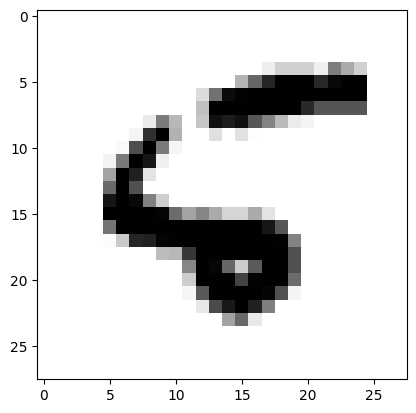

Original Labels: 5
Model prediction: 6


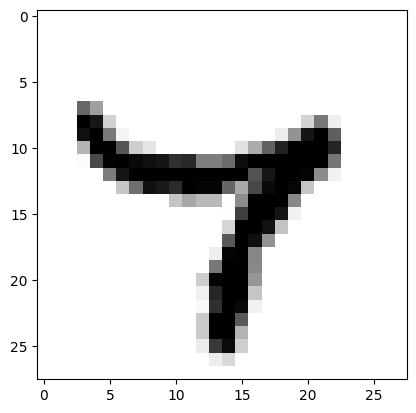

Original Labels: 7
Model prediction: 4


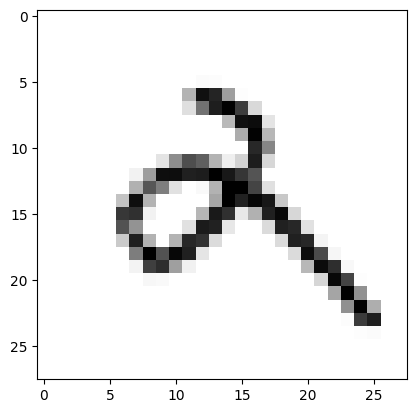

Original Labels: 2
Model prediction: 4


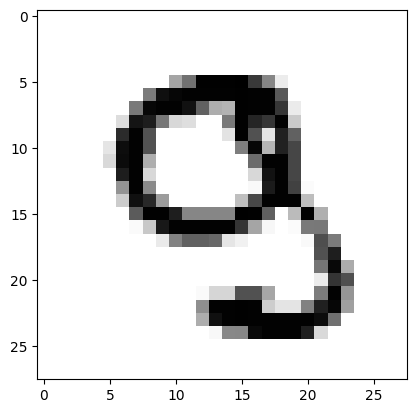

Original Labels: 9
Model prediction: 8


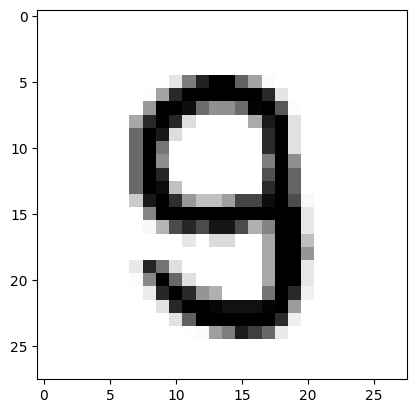

Original Labels: 9
Model prediction: 8


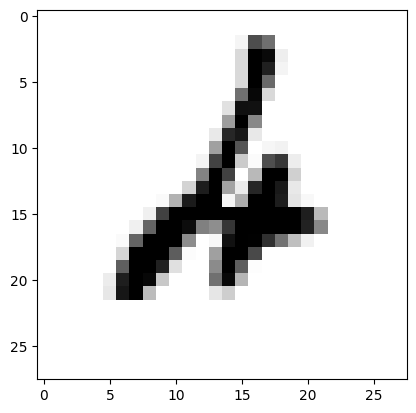

Original Labels: 4
Model prediction: 6


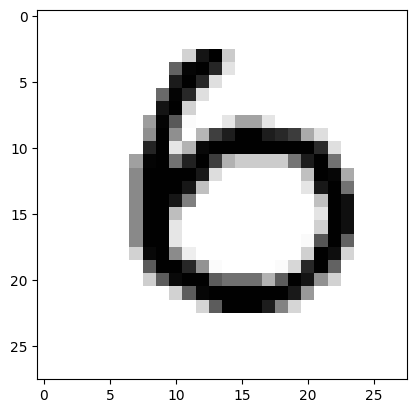

Original Labels: 6
Model prediction: 0


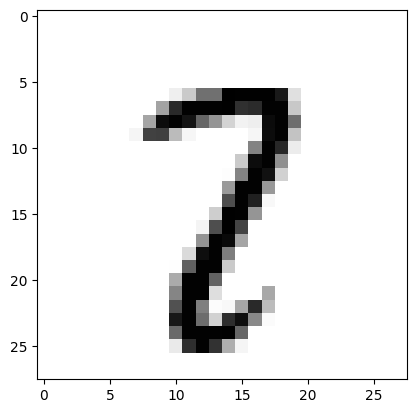

Original Labels: 2
Model prediction: 7


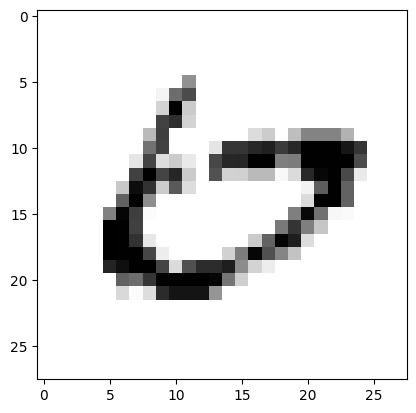

Original Labels: 6
Model prediction: 0


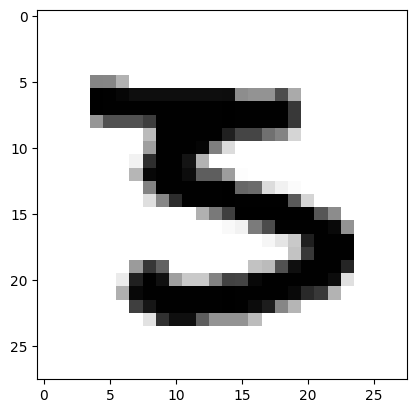

Original Labels: 3
Model prediction: 5


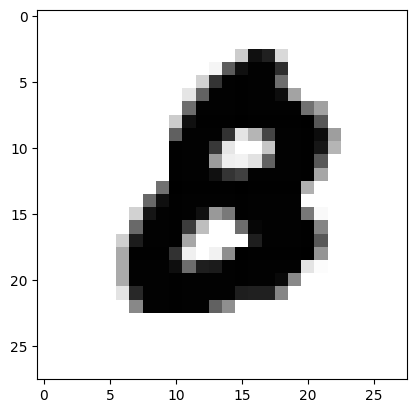

Original Labels: 8
Model prediction: 0


In [61]:
n_images = 500
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = nn_mnist(test_images)

for i in range(n_images):
    # print(predictions.numpy()[i])
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)

# Correct predictions

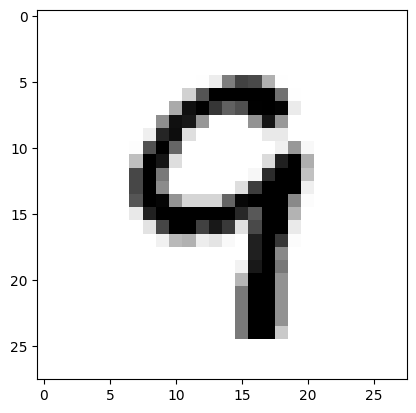

Original Labels: 9
Model prediction: 9


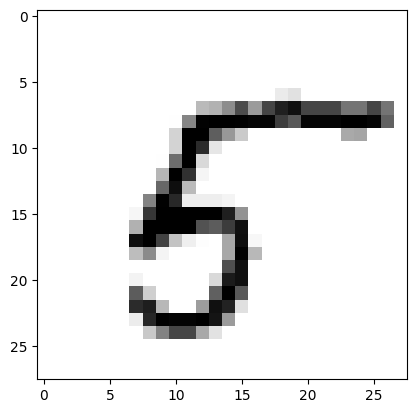

Original Labels: 5
Model prediction: 5


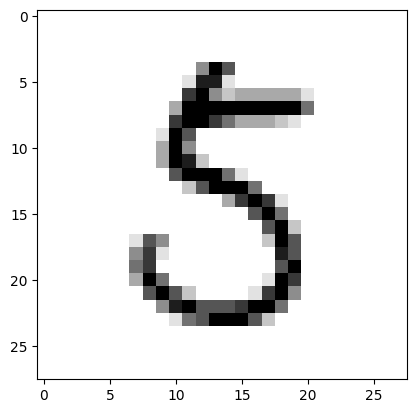

Original Labels: 5
Model prediction: 5


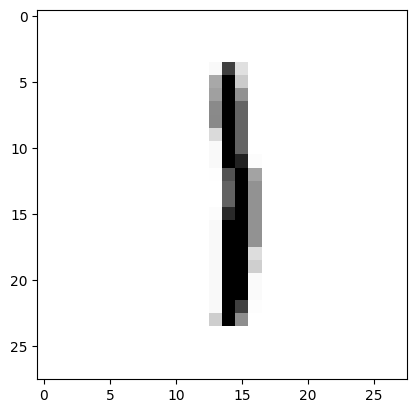

Original Labels: 1
Model prediction: 1


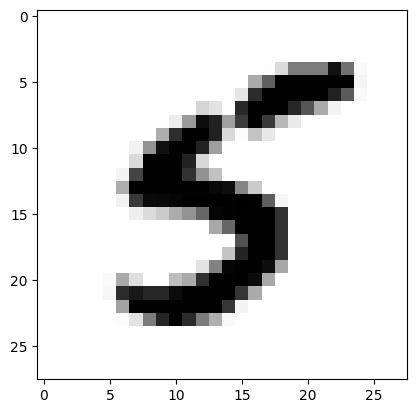

Original Labels: 5
Model prediction: 5


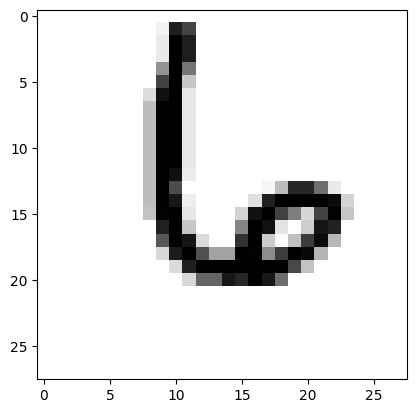

Original Labels: 6
Model prediction: 6


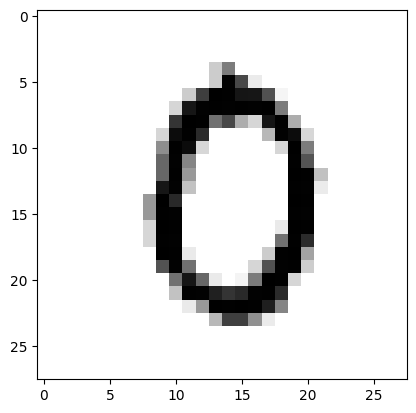

Original Labels: 0
Model prediction: 0


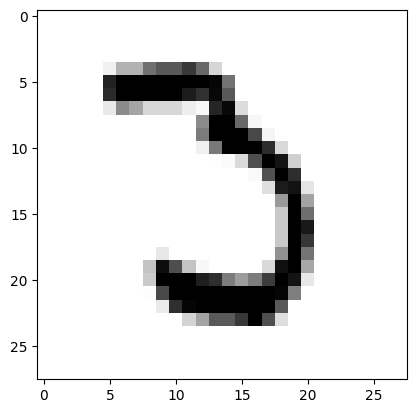

Original Labels: 3
Model prediction: 3


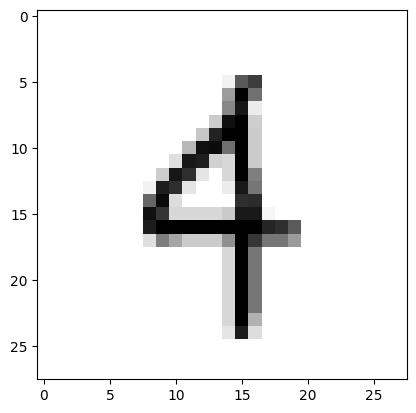

Original Labels: 4
Model prediction: 4


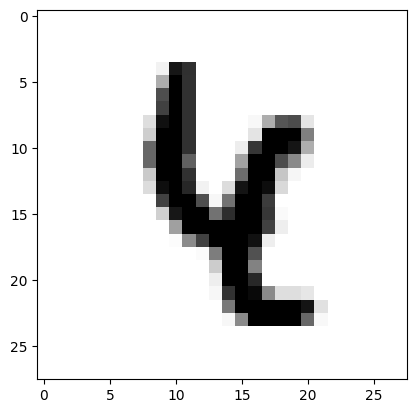

Original Labels: 4
Model prediction: 4


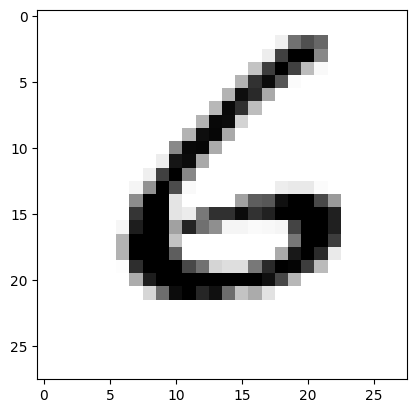

Original Labels: 6
Model prediction: 6


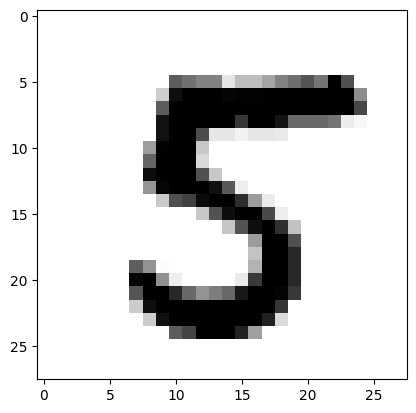

Original Labels: 5
Model prediction: 5


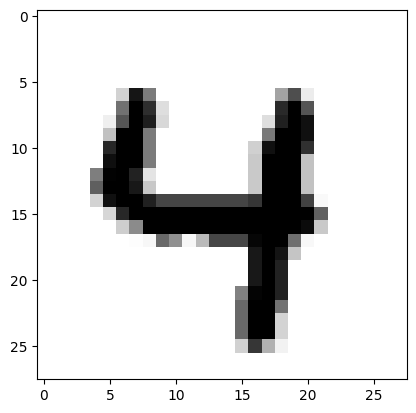

Original Labels: 4
Model prediction: 4


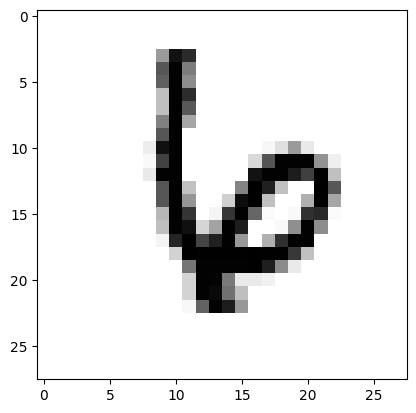

Original Labels: 6
Model prediction: 6


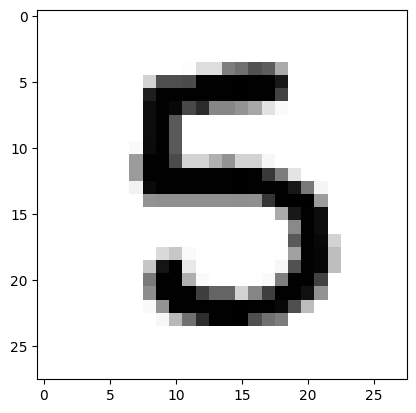

Original Labels: 5
Model prediction: 5


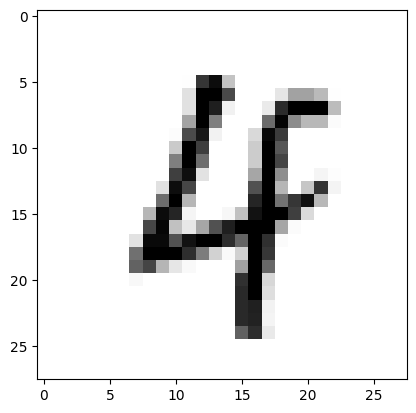

Original Labels: 4
Model prediction: 4


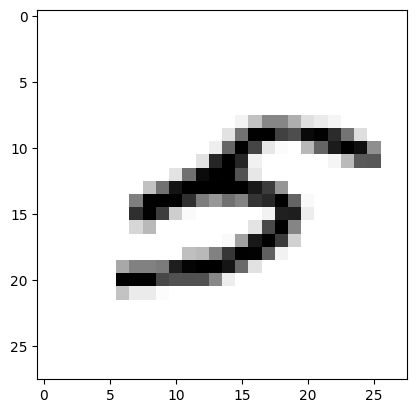

Original Labels: 5
Model prediction: 5


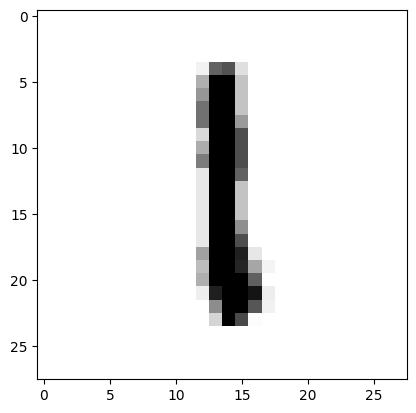

Original Labels: 1
Model prediction: 1


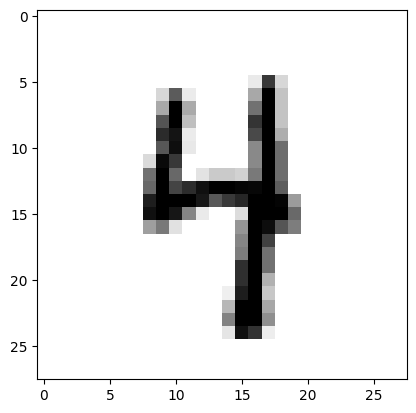

Original Labels: 4
Model prediction: 4


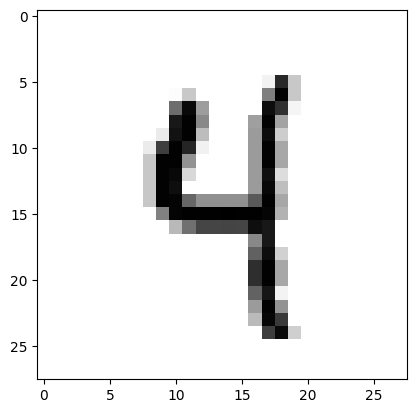

Original Labels: 4
Model prediction: 4


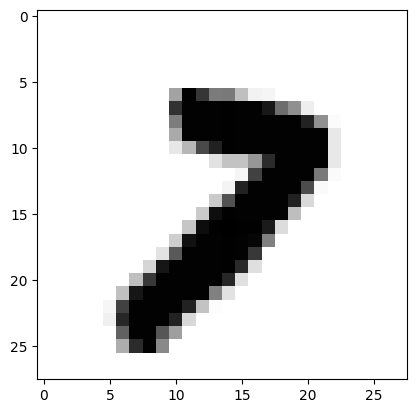

Original Labels: 7
Model prediction: 7


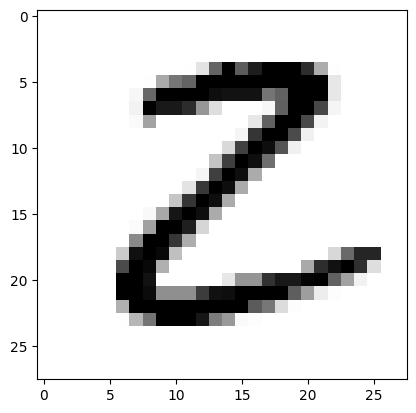

Original Labels: 2
Model prediction: 2


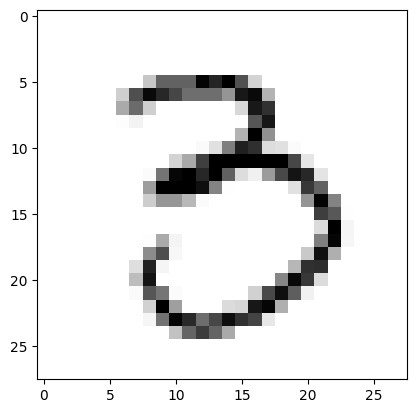

Original Labels: 3
Model prediction: 3


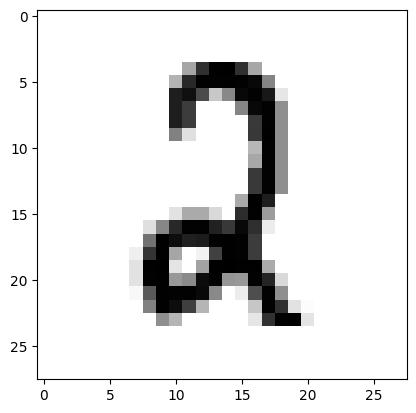

Original Labels: 2
Model prediction: 2


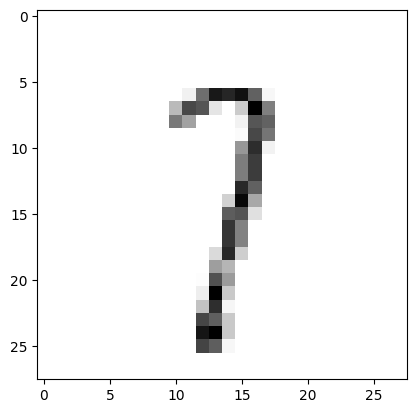

Original Labels: 7
Model prediction: 7


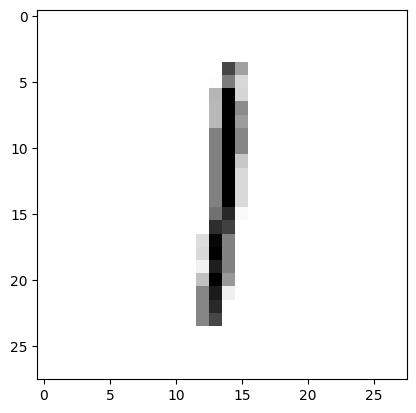

Original Labels: 1
Model prediction: 1


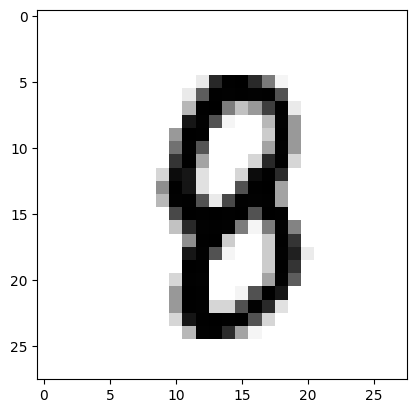

Original Labels: 8
Model prediction: 8


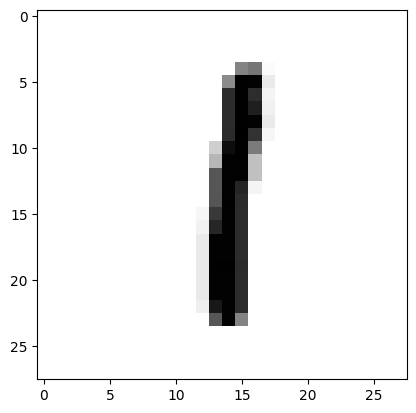

Original Labels: 1
Model prediction: 1


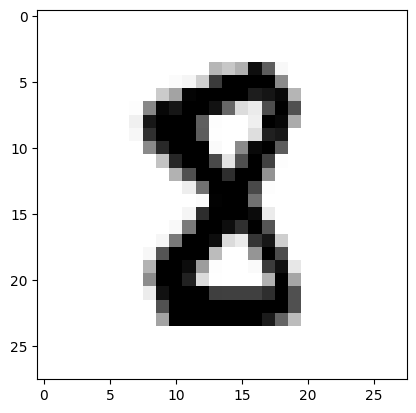

Original Labels: 8
Model prediction: 8


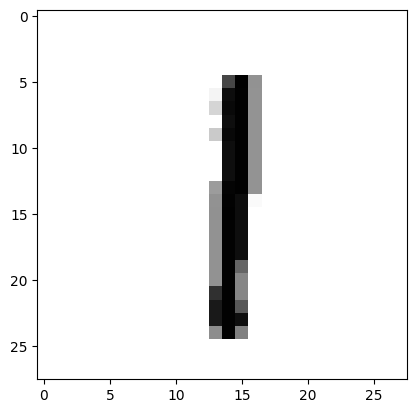

Original Labels: 1
Model prediction: 1


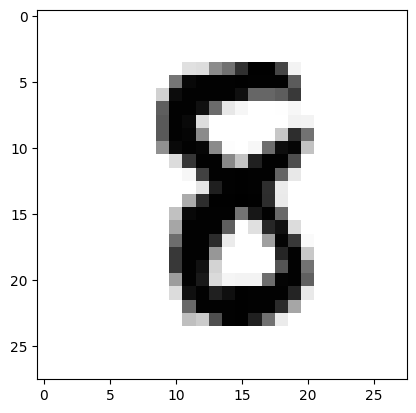

Original Labels: 8
Model prediction: 8


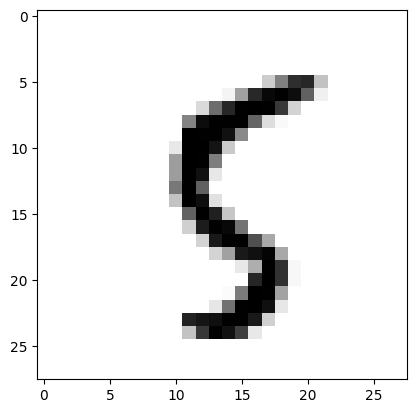

Original Labels: 5
Model prediction: 5


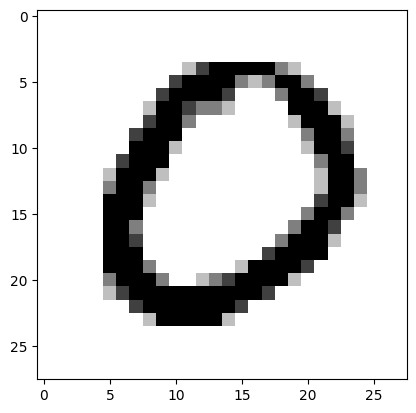

Original Labels: 0
Model prediction: 0


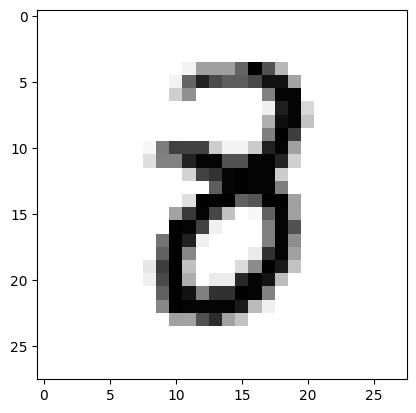

Original Labels: 8
Model prediction: 8


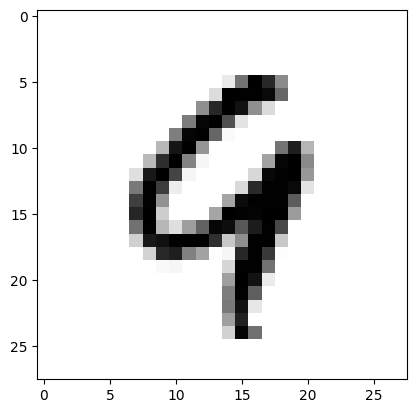

Original Labels: 9
Model prediction: 9


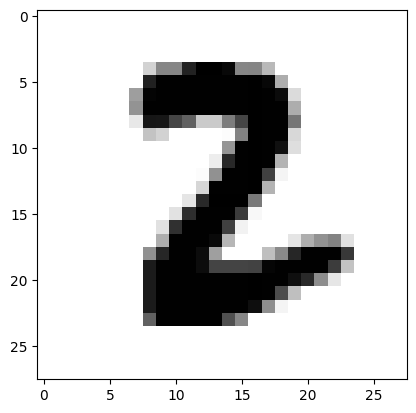

Original Labels: 2
Model prediction: 2


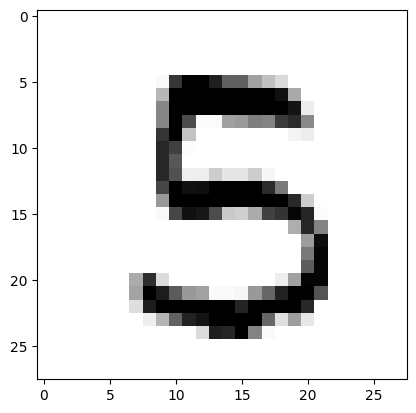

Original Labels: 5
Model prediction: 5


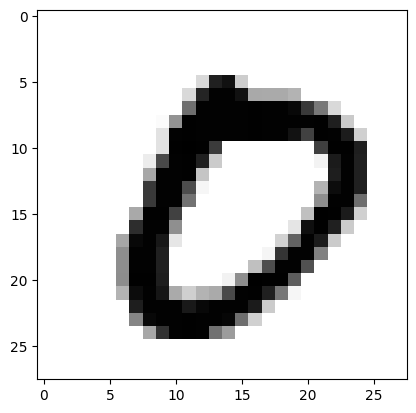

Original Labels: 0
Model prediction: 0


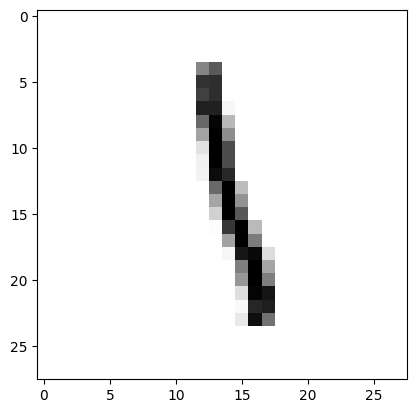

Original Labels: 1
Model prediction: 1


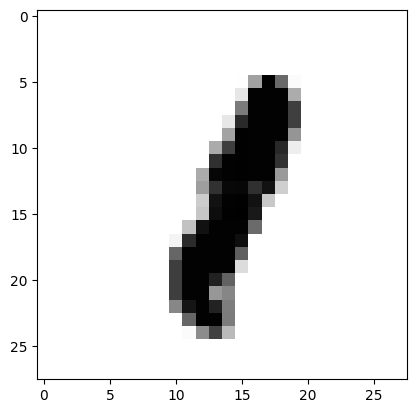

Original Labels: 1
Model prediction: 1


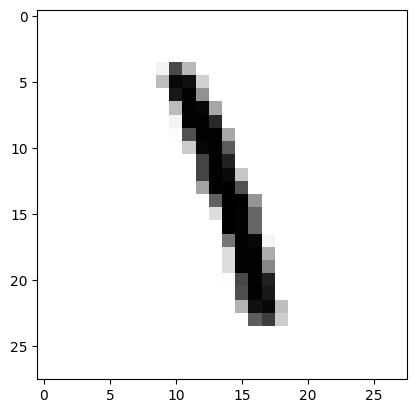

Original Labels: 1
Model prediction: 1


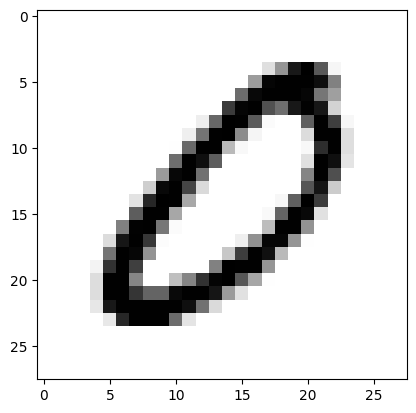

Original Labels: 0
Model prediction: 0


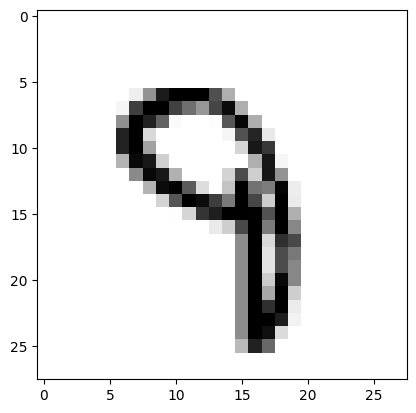

Original Labels: 9
Model prediction: 9


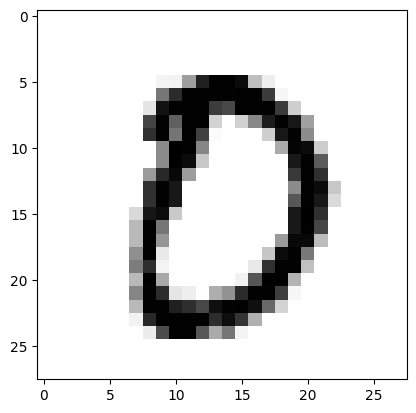

Original Labels: 0
Model prediction: 0


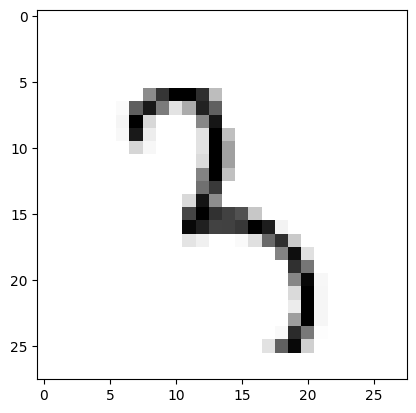

Original Labels: 3
Model prediction: 3


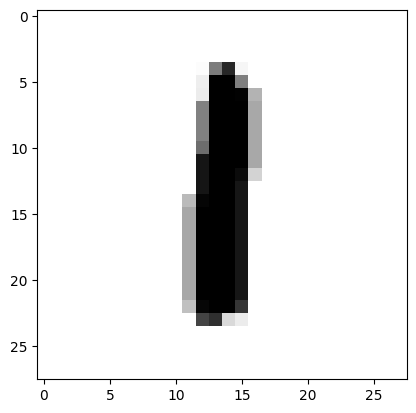

Original Labels: 1
Model prediction: 1


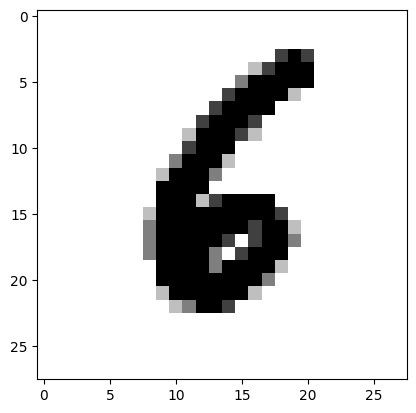

Original Labels: 6
Model prediction: 6


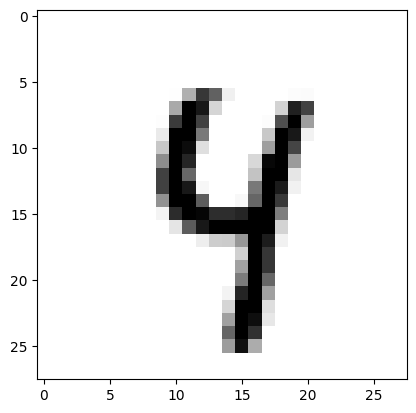

Original Labels: 4
Model prediction: 4


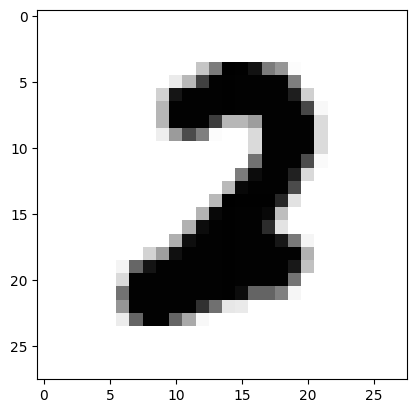

Original Labels: 2
Model prediction: 2


IndexError: index 50 is out of bounds for axis 0 with size 50

In [62]:
n_images = 200
test_images = x_test[150:n_images]
test_labels = y_test[150:n_images]
predictions = nn_mnist(test_images)

for i in range(n_images):
    # print(predictions.numpy()[i])
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction == test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)